In [1]:
import math
import os
import sys
sys.path.insert(0,'../src/')
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import seaborn as sns
from database import SQLiteDatabase
from experiment import preliminary_setup
import query

In [11]:
KWARGS = preliminary_setup()
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
register_matplotlib_converters()
DB_DIRECTORY = KWARGS['database_directory']
FIGURES_DIRECTORY = KWARGS['figure_directory']
DATABASE = SQLiteDatabase(os.path.join(DB_DIRECTORY,'deployment_strategy_3_2.db'))

RBC_REFERENCE_LOAD_SUMMARY = pd.read_csv(os.path.join(KWARGS['summary_directory'], 'rbc_reference_3_load_summary.csv'))

RBC_REFERENCE_COST_SUMMARY = pd.read_csv(os.path.join(KWARGS['summary_directory'], 'rbc_reference_3_cost_summary.csv'))
RBC_REFERENCE_COST_SUMMARY = RBC_REFERENCE_COST_SUMMARY.rename(columns={'building_id': 'deployment_building_id'})
RBC_REFERENCE_COST_SUMMARY['agent_building_id'] = RBC_REFERENCE_COST_SUMMARY['deployment_building_id']

NO_TRANSFER_COST_SUMMARY = pd.read_csv(os.path.join(KWARGS['summary_directory'], 'deployment_strategy_3_0_cost_summary.csv'))
NO_TRANSFER_COST_SUMMARY = NO_TRANSFER_COST_SUMMARY.rename(columns={'building_id': 'deployment_building_id'})
NO_TRANSFER_COST_SUMMARY['agent_building_id'] = NO_TRANSFER_COST_SUMMARY['deployment_building_id']

GRID = DATABASE.get_table('grid')
GRID = GRID.rename(columns={'building':'deployment_building_id'})
GRID['deployment_building_id'] = GRID['deployment_building_id'].str.split('_', expand=True)[1].astype(int)

cost_labels = {
    'electricity_consumption': r'$D$', 
    'price': r'$C$', 
    'carbon_emission': r'$G$',
    'zero_net_energy': r'$Z$',
    'daily_peak': r'$P$',
    'ramping': r'$R$',
    'load_factor': r'$1 - L$',
}

# Building-Level Scores

In [3]:
building_cost_data = DATABASE.query_table(query.get_building_cost_summary())
building_cost_data = building_cost_data.rename(columns={'building_id':'agent_building_id'})
grid = GRID[['deployment_building_id', 'simulation_group']].drop_duplicates()
building_cost_data = grid.merge(building_cost_data, on='simulation_group', how='left')

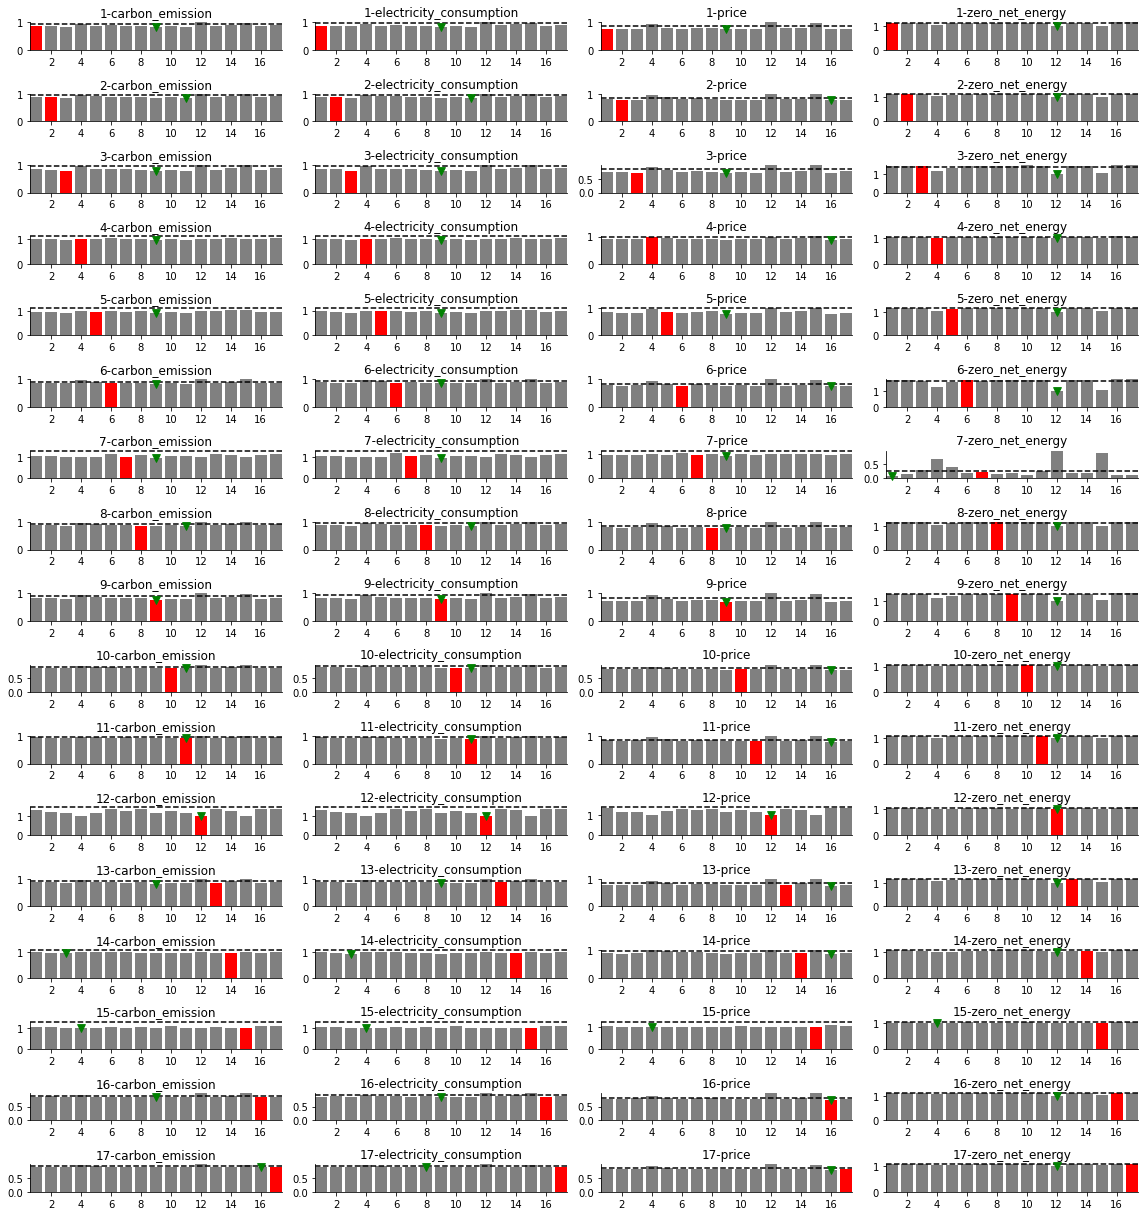

In [4]:
costs = ['zero_net_energy', 'price', 'electricity_consumption', 'carbon_emission']
row_count = len(building_cost_data['deployment_building_id'].unique())
column_count = len(costs)
cmap = 'coolwarm'
plot_data = building_cost_data[
    (building_cost_data['episode']==building_cost_data['episode'].max())
    &(building_cost_data['cost'].isin(costs))
].copy()
tf_plot_data = plot_data.sort_values(['agent_building_id'])
fig, ax = plt.subplots(row_count, column_count, figsize=(4*column_count,1.0*row_count), sharex=False, sharey=False)

for i, (ax, ((b, c), c_data)) in enumerate(zip(fig.axes, tf_plot_data.groupby(['deployment_building_id', 'cost']))):
    colors = ['grey']*c_data.shape[0]
    colors[b - 1] = 'red'
    x, y = c_data['agent_building_id'].tolist(), c_data['value'].tolist()
    mini_ixs = [i for i in  range(len(x)) if y[i] == min(y)]
    patches = ax.bar(x, y, color=colors)
    rbc_value = RBC_REFERENCE_COST_SUMMARY[
        (RBC_REFERENCE_COST_SUMMARY['agent_building_id']==b) 
        & (RBC_REFERENCE_COST_SUMMARY['cost']==c)
    ]['value'].iloc[0]
    ax.axhline(rbc_value, linestyle='--', color='black', clip_on=False)
    ax.set_title(f'{b}-{c}')
    ax.tick_params('x', which='both', rotation=0)

    for i in mini_ixs:
        b_x, b_y = [i + 1], [y[i]]
        ax.scatter(b_x, b_y, color='green', clip_on=False, marker='v', zorder=100, s=60)

    for s in ['right','top']:
        ax.spines[s].set_visible(False)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(2))

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIRECTORY,f'deployment_strategy_3_2_building_cost_summary.pdf'),bbox_inches='tight',transparent=True)
plt.show()

- maybe small multiples of bar plots will show the data better?
- What is going on with building 7 having really low ZNE on transfer even lower than it's self trained model?
- How do these buildings actually compare; what are their similarities? Cluster their daily profile?
- If what i have plotted and simulated is correct, you get similar performance if you

Summary grouping: agent_building_id


,cost,agent_building_id,mean,std,polarity
0,carbon_emission,1,0.098224,0.121979,+
1,carbon_emission,2,0.065209,0.100276,+
2,carbon_emission,3,0.121268,0.089996,+
3,carbon_emission,4,-0.026546,0.026704,-
4,carbon_emission,5,-0.023875,0.076450,-
5,carbon_emission,6,0.107196,0.138511,+
6,carbon_emission,7,-0.112170,0.106891,-
7,carbon_emission,8,0.082149,0.135249,+
8,carbon_emission,9,0.134051,0.090850,+
9,carbon_emission,10,0.053890,0.116072,+


mean             std          
                                 count      mean count      mean
cost                    polarity                                
carbon_emission         +           10  0.093017    10  0.121041
                        -            7 -0.026194     7  0.061908
electricity_consumption +           10  0.086024    10  0.115802
                        -            7 -0.021179     7  0.058568
price                   +           12  0.082320    12  0.137302
                        -            5 -0.031417     5  0.060442
zero_net_energy         +            9  0.135750     9  0.214191
                        -            8 -0.178920     8  0.294863

Summary grouping: deployment_building_id


,cost,deployment_building_id,mean,std,polarity
0,carbon_emission,1,0.034902,0.051246,+
1,carbon_emission,2,0.031406,0.046727,+
2,carbon_emission,3,0.072218,0.064500,+
3,carbon_emission,4,0.016906,0.022053,+
4,carbon_emission,5,-0.001809,0.035108,-
5,carbon_emission,6,0.028125,0.051935,+
6,carbon_emission,7,0.027935,0.065599,+
7,carbon_emission,8,0.037669,0.044116,+
8,carbon_emission,9,0.079090,0.065578,+
9,carbon_emission,10,0.027792,0.037705,+


mean             std          
                                 count      mean count      mean
cost                    polarity                                
carbon_emission         +           16  0.046788    16  0.049194
                        -            1 -0.001809     1  0.035108
electricity_consumption +           16  0.044562    16  0.047619
                        -            1 -0.001006     1  0.035386
price                   +           15  0.060394    15  0.071914
                        -            2 -0.037576     2  0.053331
zero_net_energy         +            5  0.040556     5  0.079633
                        -           12 -0.034366    12  0.072065

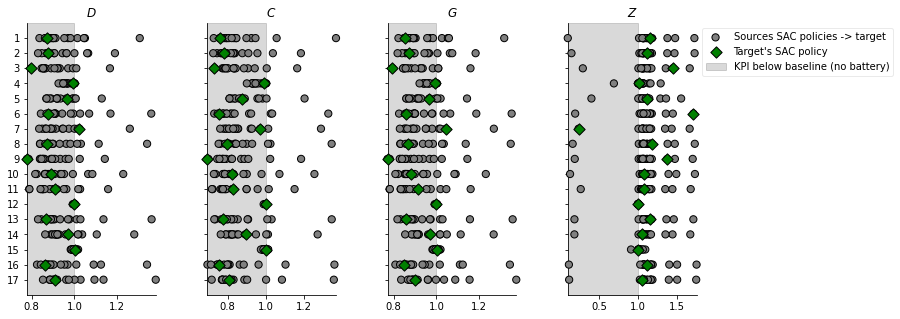

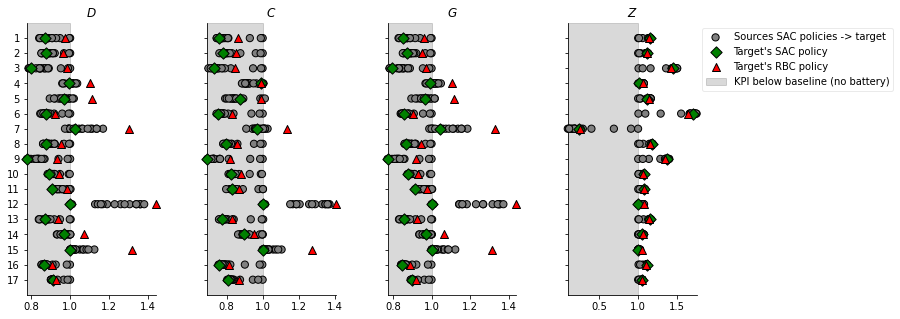

In [13]:
row_count = 1
column_count = len(tf_plot_data['cost'].unique())
marker_size = 8
edgecolor = 'black'
linewidth = 1
group_columns = ['agent_building_id', 'deployment_building_id']

for c in group_columns:
    summary_data = tf_plot_data.copy()
    self_data = summary_data[(summary_data['deployment_building_id'] == summary_data['agent_building_id'])].copy()
    self_data = self_data.rename(columns={'value': 'ref_value'})
    summary_data = summary_data.drop(self_data.index)
    rbc_data = RBC_REFERENCE_COST_SUMMARY.copy()
    rbc_data = rbc_data.rename(columns={'value': 'rbc_value'})
    summary_data = summary_data.merge(self_data[['cost', 'ref_value', c]], on=['cost', c], how='left')
    summary_data = summary_data.merge(rbc_data[['cost', 'rbc_value', 'deployment_building_id']], on=['cost', 'deployment_building_id'], how='left')
    negative_transfer_summary = summary_data.copy()
    negative_transfer_summary['difference'] = negative_transfer_summary['value'] - negative_transfer_summary['rbc_value']
    negative_transfer_summary['polarity'] = negative_transfer_summary['difference']/negative_transfer_summary['difference'].abs()
    negative_transfer_summary = negative_transfer_summary.groupby(['cost', 'deployment_building_id', 'polarity']).size().reset_index(name='count')
    summary_data['difference'] = summary_data['value'] - summary_data['ref_value']
    summary_data = summary_data.groupby(['cost', c,])[['difference']].agg(['mean', 'std'])
    summary_data.columns = ['mean', 'std']
    summary_data = summary_data.reset_index()
    summary_data['polarity'] = '+'
    summary_data.loc[summary_data['mean'] < 0, 'polarity'] = '-'
    summary_data.loc[summary_data['mean'] == 0, 'polarity'] = ':'
    average_summary_data = summary_data.groupby(['cost', 'polarity'])[['mean', 'std']].agg(['count', 'mean'])
    print('Summary grouping:', c)
    # display(negative_transfer_summary)
    display(summary_data)
    display(average_summary_data)

for x, t in zip(['agent', 'deployment'], ['Source', 'Target']):
    fig, _ = plt.subplots(row_count, column_count, figsize=(3.0*column_count, 5.0*row_count), sharey=True, gridspec_kw={'wspace': 0.4})
    
    for i, (ax, c) in enumerate(zip(fig.axes, cost_labels)):
        c_data = tf_plot_data[tf_plot_data['cost']==c].copy()
        d_c_data = c_data[c_data['deployment_building_id'] == c_data['agent_building_id']][[
            'deployment_building_id', 'value'
        ]].copy()
        rbc_data = RBC_REFERENCE_COST_SUMMARY[(RBC_REFERENCE_COST_SUMMARY['cost']==c)].copy()
        building_ids = sorted(c_data[f'{x}_building_id'].unique().tolist())

        sns.stripplot(y=f'{x}_building_id', x='value', data=c_data, ax=ax, color='grey', jitter=False, clip_on=False, size=marker_size*0.9, edgecolor=edgecolor, linewidth=linewidth, orient='h', label='Sources SAC policies -> target')
        sns.stripplot(y='deployment_building_id', x='value', data=d_c_data,  ax=ax, color='green', jitter=False, clip_on=False, size=marker_size, edgecolor=edgecolor, linewidth=linewidth, marker='D', orient='h', label='Target\'s SAC policy')
        

        if x == 'deployment':
            rbc = sns.stripplot(y='agent_building_id', x='value', data=rbc_data, ax=ax, color='red', jitter=False, clip_on=False, size=marker_size, edgecolor=edgecolor, linewidth=linewidth, marker='^', orient='h', label='Target\'s RBC policy')
        else:
            pass

        ax.fill_betweenx(y=range(-1, len(building_ids) + 1), x1=c_data['value'].min(), x2=1.0, label='KPI below baseline (no battery)', zorder=0, color='black', alpha=0.15)

        for s in ['right','top']:
            ax.spines[s].set_visible(False)

        ax.set_xlabel(None)
        ax.set_ylabel(None)

        if i == column_count - 1:
            handles, labels = ax.get_legend_handles_labels()
            unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
            ax.legend(bbox_to_anchor=(1.0,1.0), loc='upper left', framealpha=0.4, ncol=1, *zip(*unique))
        else:
            pass

        ax.yaxis.set_major_locator(ticker.FixedLocator([i - 1 for i in building_ids]))
        ax.set_yticklabels(building_ids)
        ax.set_title(cost_labels[c])

    plt.savefig(os.path.join(FIGURES_DIRECTORY,f'deployment_strategy_3_2_{t.lower()}_building_cost_summary.pdf'),bbox_inches='tight',transparent=True)
    plt.show()

In [12]:
# row_count = 1
# column_count = 1
# marker_size = 8
# edgecolor = 'black'
# linewidth = 1


# group_columns = ['agent_building_id', 'deployment_building_id']

# for c in group_columns:
#     summary_data = tf_plot_data[
#         (tf_plot_data['cost'].isin(['price', 'zero_net_energy']))
#         # (~tf_plot_data['deployment_building_id'].isin([12, 15])) 
#         # & (~tf_plot_data['agent_building_id'].isin([12, 15]))
#     ].copy()
#     self_data = summary_data[(summary_data['deployment_building_id'] == summary_data['agent_building_id'])].copy()
#     self_data = self_data.rename(columns={'value': 'ref_value'})
#     summary_data = summary_data.drop(self_data.index)
#     rbc_data = RBC_REFERENCE_COST_SUMMARY.copy()
#     rbc_data = rbc_data.rename(columns={'value': 'rbc_value'})
#     summary_data = summary_data.merge(self_data[['cost', 'ref_value', c]], on=['cost', c], how='left')
#     summary_data = summary_data.merge(rbc_data[['cost', 'rbc_value', 'deployment_building_id']], on=['cost', 'deployment_building_id'], how='left')
#     negative_transfer_summary = summary_data.copy()
#     negative_transfer_summary['difference'] = negative_transfer_summary['value'] - negative_transfer_summary['rbc_value']
#     negative_transfer_summary['polarity'] = negative_transfer_summary['difference']/negative_transfer_summary['difference'].abs()
#     negative_transfer_summary = negative_transfer_summary.groupby(['cost', 'deployment_building_id', 'polarity']).size().reset_index(name='count')
#     summary_data['difference'] = summary_data['value'] - summary_data['ref_value']
#     summary_data = summary_data.groupby(['cost', c,])[['difference']].agg(['mean', 'std'])
#     summary_data.columns = ['mean', 'std']
#     summary_data = summary_data.reset_index()
#     summary_data['polarity'] = '+'
#     summary_data.loc[summary_data['mean'] < 0, 'polarity'] = '-'
#     summary_data.loc[summary_data['mean'] == 0, 'polarity'] = ':'
#     average_summary_data = summary_data.groupby(['cost', 'polarity'])[['mean', 'std']].agg(['count', 'mean'])
#     print('Summary grouping:', c)
#     # display(negative_transfer_summary)
#     display(summary_data)
#     display(average_summary_data)

# for c, c_data in tf_plot_data.groupby(['cost']):
#     for x, t in zip(['agent', 'deployment'], ['Source', 'Target']):
#         d_c_data = c_data[c_data['deployment_building_id'] == c_data['agent_building_id']][[
#             'deployment_building_id', 'value'
#         ]].copy()
#         rbc_data = RBC_REFERENCE_COST_SUMMARY[(RBC_REFERENCE_COST_SUMMARY['cost']==c)].copy()
#         fig, ax = plt.subplots(row_count, column_count, figsize=(6*column_count, 2.0*row_count))
#         sns.stripplot(x=f'{x}_building_id', y='value', data=c_data, ax=ax, color='grey', jitter=False, clip_on=False, size=marker_size*0.9, edgecolor=edgecolor, linewidth=linewidth, label='Target != Source')
#         sns.stripplot(x='deployment_building_id', y='value', data=d_c_data,  ax=ax, color='green', jitter=False, clip_on=False, size=marker_size, edgecolor=edgecolor, linewidth=linewidth, marker='D', label='Target = Source')

#         if x == 'deployment':
#             rbc = sns.stripplot(x='agent_building_id', y='value', data=rbc_data, ax=ax, color='red', jitter=False, clip_on=False, size=marker_size, edgecolor=edgecolor, linewidth=linewidth, marker='^', label='RBC')
#         else:
#             pass

#         for s in ['right','top']:
#             ax.spines[s].set_visible(False)

#         ax.set_xlabel(f'{t} building')
#         ax.set_ylabel(None)
#         handles, labels = ax.get_legend_handles_labels()
#         unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
#         ax.legend(bbox_to_anchor=(1.0,1.0), loc='upper left', framealpha=0, ncol=1, *zip(*unique))
#         building_ids = sorted(c_data[f'{x}_building_id'].unique().tolist())
#         ax.xaxis.set_major_locator(ticker.FixedLocator([i - 1 for i in building_ids]))
#         ax.set_xticklabels(building_ids)
#         ax.set_title(c)

#         plt.savefig(os.path.join(FIGURES_DIRECTORY,f'deployment_strategy_3_2_{t.lower()}_building_{c}_cost_summary.pdf'),bbox_inches='tight',transparent=True)
#         plt.show()

In [10]:
# row_count = 1
# column_count = 1
# marker_size = 8
# edgecolor = 'black'
# linewidth = 1

# for c, c_data in tf_plot_data.groupby(['cost']):
#     print(c)
#     d_c_data = c_data[c_data['deployment_building_id'] == c_data['agent_building_id']][[
#         'deployment_building_id', 'value'
#     ]].copy()
#     s_data = c_data.drop(d_c_data.index)[['agent_building_id', 'value']].copy()
#     s_data = s_data.rename(columns={'agent_building_id': 'building_id'})
#     s_data['label'] = 'Source'
#     t_data = c_data.drop(d_c_data.index)[['deployment_building_id', 'value']].copy()
#     t_data = t_data.rename(columns={'deployment_building_id': 'building_id'})
#     t_data['label'] = 'Target'
#     c_data = pd.concat([s_data, t_data], ignore_index=True, sort=False)
#     rbc_data = RBC_REFERENCE_COST_SUMMARY[(RBC_REFERENCE_COST_SUMMARY['cost']==c)].copy()
    
#     fig, ax = plt.subplots(row_count, column_count, figsize=(12*column_count, 2.0*row_count))
#     sns.stripplot(x=f'building_id', y='value', data=c_data, ax=ax, hue='label', jitter=False, dodge=True, clip_on=False, size=marker_size*0.9, edgecolor=edgecolor, linewidth=linewidth)
#     sns.stripplot(x='deployment_building_id', y='value', data=d_c_data,  ax=ax, color='green', jitter=False, clip_on=False, size=marker_size*0.9, edgecolor=edgecolor, linewidth=linewidth, marker='D', label='Target = Source')

#     if x == 'deployment':
#         sns.stripplot(x='agent_building_id', y='value', data=rbc_data, ax=ax, color='red', jitter=False, clip_on=False, size=marker_size, edgecolor=edgecolor, linewidth=linewidth, marker='^', label='RBC')
#     else:
#         pass

#     for s in ['right','top']:
#         ax.spines[s].set_visible(False)

#     ax.set_xlabel(f'Building')
#     ax.set_ylabel(None)
#     handles, labels = ax.get_legend_handles_labels()
#     unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
#     ax.legend(bbox_to_anchor=(0.5, -0.3), loc='upper center', framealpha=0, ncol=4, *zip(*unique))
#     building_ids = sorted(c_data[f'building_id'].unique().tolist())
#     ax.xaxis.set_major_locator(ticker.FixedLocator([i - 1 for i in building_ids]))
#     ax.set_xticklabels(building_ids)
#     ax.set_xticks([i - 0.5 for i in building_ids], minor=True)
#     ax.grid(visible=True, which='minor', axis='x')

#     # plt.savefig(os.path.join(FIGURES_DIRECTORY,f'deployment_strategy_3_2_{t.lower()}_building_{c}_cost_summary.pdf'),bbox_inches='tight',transparent=True)
#     plt.show()
#     # assert False

# District-Level Scores

In [7]:
district_cost_data = DATABASE.query_table(query.get_transfer_learning_district_cost_summary())

difference                              
                               min       max      mean       std
cost                                                            
carbon_emission           0.048872  0.151145  0.097620  0.028478
daily_peak                0.009168  0.221288  0.077359  0.061737
electricity_consumption   0.038389  0.138785  0.088244  0.028702
load_factor               0.042741  0.075153  0.058238  0.011243
price                     0.059126  0.228182  0.112683  0.051388
ramping                   0.265920  0.480058  0.355218  0.071232
zero_net_energy          -0.074897  0.050105  0.021459  0.038896

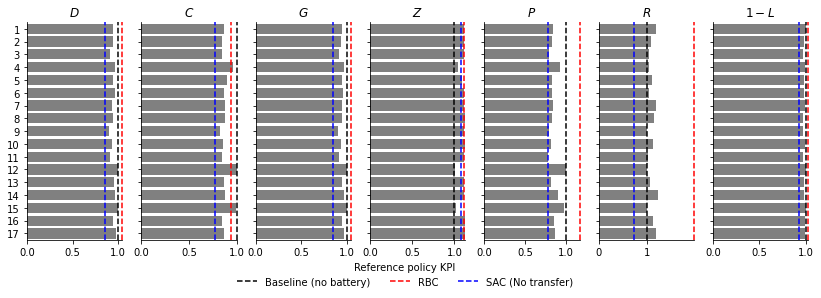

In [15]:
column_count_limit = 7
costs = district_cost_data['cost'].unique()
row_count = math.ceil(len(costs)/column_count_limit)
column_count = min(column_count_limit, len(costs))
fig, _ = plt.subplots(row_count, column_count, figsize=(column_count*2.0, row_count*4.0), gridspec_kw={'wspace': 0.2}, sharey=True)
plot_data = district_cost_data[district_cost_data['episode']==district_cost_data['episode'].max()].copy()
plot_data['agent'] = 'SAC'
summary_data = plot_data.copy()
no_transfer_data = NO_TRANSFER_COST_SUMMARY[
    (NO_TRANSFER_COST_SUMMARY['episode']==NO_TRANSFER_COST_SUMMARY['episode'].max()) & (NO_TRANSFER_COST_SUMMARY['scope']=='district')
].copy()
no_transfer_data = no_transfer_data.rename(columns={'value': 'no_transfer_value'})
summary_data = summary_data.merge(no_transfer_data[['cost', 'no_transfer_value']], on=['cost'], how='left')
summary_data['difference'] = summary_data['value'] - summary_data['no_transfer_value']
summary_data = summary_data.groupby(['cost'])[['difference']].agg(['min', 'max', 'mean', 'std'])
display(summary_data)

for ax in fig.axes[len(costs):]:
    ax.set_visible(False)

for i, (ax, c) in enumerate(zip(fig.axes, cost_labels)):
    c_data = district_cost_data[district_cost_data['cost']==c].sort_values('source_building_id')
    c_data['source_building_id'] = c_data['source_building_id'].astype(str)
    sns.barplot(x='value', y='source_building_id', data=c_data, ax=ax, color='grey', clip_on=False)
    # sns.scatterplot(x='value', y='source_building_id', data=c_data, ax=ax, color='grey', clip_on=False, s=60)
    rbc_value = RBC_REFERENCE_COST_SUMMARY[
        (RBC_REFERENCE_COST_SUMMARY['cost']==c) & (RBC_REFERENCE_COST_SUMMARY['scope']=='district')
    ]['value'].iloc[0]
    no_transfer_value = NO_TRANSFER_COST_SUMMARY[
        (NO_TRANSFER_COST_SUMMARY['episode']==NO_TRANSFER_COST_SUMMARY['episode'].max()) & (NO_TRANSFER_COST_SUMMARY['cost']==c) & (NO_TRANSFER_COST_SUMMARY['scope']=='district')
    ]['value'].iloc[0]
    ax.axvline(1.0, color='black', linestyle='--', label='Baseline (no battery)', clip_on=False)
    ax.axvline(rbc_value, color='red', linestyle='--', label='RBC', clip_on=False)
    ax.axvline(no_transfer_value, color='blue', linestyle='--', label='SAC (No transfer)', clip_on=False)
    ax.set_xlabel(None)
    ax.set_title(cost_labels[c])

    for s in ['right','top']:
        ax.spines[s].set_visible(False)

    # for j, p in enumerate(ax.patches):
    #     # ax.text(c_data['value'].max(), p.get_y() + p.get_height()/2.0, f'{p.get_width():0.2f}', ha='left', va='center')

    #     if round(p.get_width(), 2) == c_data['value'].round(2).min():
    #         # p.set_hatch('/')
    #         p.set_color('green')
    #     else:
    #         pass
    
    if i == len(costs) - 1:
        ax.legend(
            title='Reference policy KPI',
            bbox_to_anchor=(0.5, 0.08),
            loc='upper center', 
            bbox_transform=fig.transFigure,
            framealpha=0,
            ncol=3
        )
    else:
        pass

    if i == 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel(None)

plt.savefig(os.path.join(FIGURES_DIRECTORY,f'deployment_strategy_3_2_district_cost_summary.pdf'),bbox_inches='tight',transparent=True)
# plt.tight_layout()
plt.show()


# Save

In [9]:
building_cost_data['scope'] = 'building'
pd.concat([building_cost_data,], ignore_index=True, sort=False).to_csv(
    os.path.join(KWARGS['summary_directory'], 'deployment_strategy_3_2_cost_summary.csv'), index=False
)